# Simulating PSF variation within JWST instruments

WebbPSF version 0.6 added models for science instrument contributions to overall wavefront error based on real ground testing data (rather than statistical realizations of the requirements). These are enabled by default since version 0.6, to provide the most realistic PSF by default. This notebook demonstrates how to effectively use the SI WFE models to examine PSF variation based on field position and wavelength.

First, import the necessary packages:

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib
matplotlib.rc('image', interpolation='nearest')
import matplotlib.pyplot as plt

import webbpsf
print("Tested with WebbPSF 0.6.0, currently running on WebbPSF", webbpsf.version.version)

Tested with WebbPSF 0.6.0, currently running on WebbPSF 0.6.0rc1


### Disclaimers

 * The per-instrument wavefront error models still require validation and sign-offs from the SI teams.
 * Wavefront error maps were computed at specific field points; WebbPSF currently chooses the map for the nearest field point rather than interpolating across the SI field of view.
 * These models were derived from CV3 ground testing and will evolve as better information becomes available.

**Report any bugs you encounter on our [Issue Tracker](https://github.com/mperrin/webbpsf/issues/new).**

## What does this do and how does it work?

The goal is to put measured wavefront error maps from ground testing of the JWST instruments into the WebbPSF models.

These SI WFE models use Zernike polynomial coefficients to build up an OPD map for the wavefront error at specific field points. The coefficients were derived from fitting Zernike polynomials to the WFE maps for various field points in the instrument fields of view. Using Zernike polynomial terms up to $Z_{36}$ was found to give residuals under 10 nanometers RMS when fitting the wavefront maps (as determined by wavefront sensing) from the David Aronstein and the JWST ISIM Optics Group at Goddard Space Flight Center.

The OPD map is generated on the fly by WebbPSF and inserted as a virtual optical element in the JWST instrument model.

## Example: Compare the MIRI PSF at two field positions

Let's create an instance of the MIRI instrument model and display the planes in its optical train.

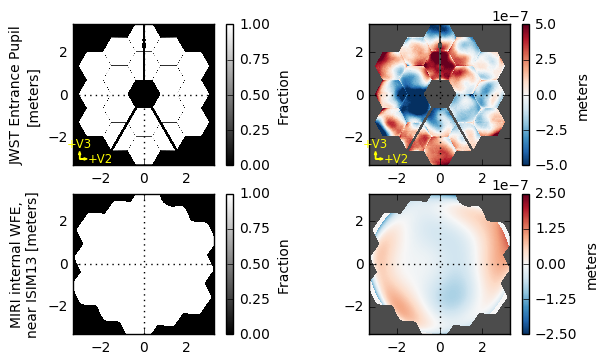

In [2]:
miri = webbpsf.MIRI()
plt.figure(figsize=(7, 4))
miri.display()

The contributions to wavefront error can be separated into:

  1. OTE wavefront error (due to variations in the telescope optics common to all instruments)
  2. static SI wavefront error (due to variations in the specific science instrument's optics)
  3. field dependent SI wavefront error (due to variation in the PSF based on the position of the source within the field of view)

The first two components are combined in the `pupilopd` map shown in the top right panel. The last component of the model is generated at runtime from a Zernike coefficient lookup table. The `include_si_wfe` attribute switches this last component of the model on and off.

By default (since WebbPSF 0.6), it is enabled:

In [3]:
miri.include_si_wfe

True

Turning off the OTE and static SI WFE makes it easier to see the small differences from the instrument internal WFE. That is accomplished by setting the pupil OPD map to `None`.

In [4]:
miri.pupilopd = None

Now we ask WebbPSF to display the instrument optical train again:

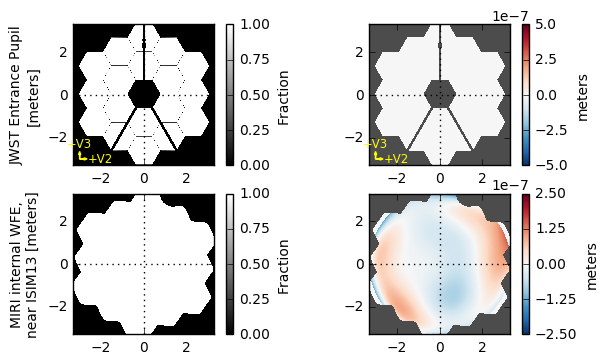

In [5]:
plt.figure(figsize=(7, 4))
miri.display()

The plane for the internal WFE contribution is visible in the row labeled "MIRI internal WFE near ISIM13". ISIM13 is the designation of the field point from which the wavefront map was taken.

*Note: The circle on which the Zernike terms are computed appears undersized because MIRI includes a 4% oversized pupil stop, but WebbPSF does not attempt to model wavefront errors beyond the extent of the OTE pupil.*

The SI wavefront error model has been sampled at various field points. WebbPSF accepts a detector pixel position, from which it determines the wavefront error map at the nearest sampled point. (WebbPSF does not currently interpolate between points.)

The default is the center of the detector:

In [6]:
miri.detector_position

(512, 512)

Let's compute a PSF here and call it `miri_psf_center`:

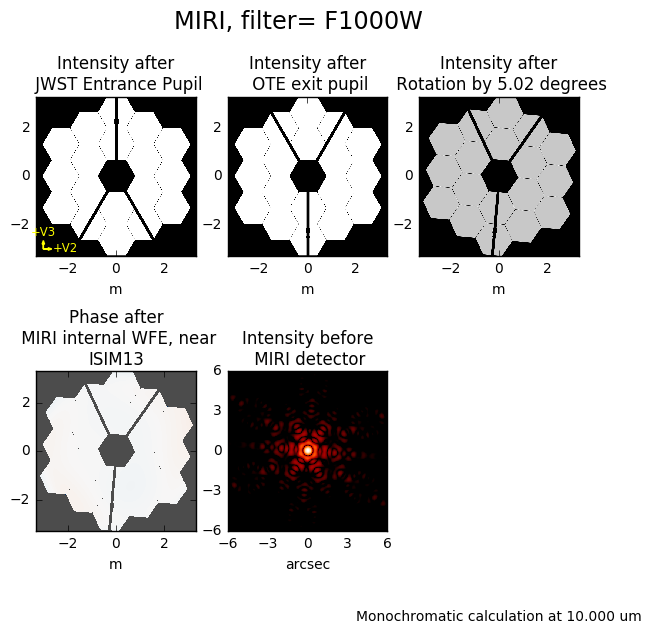

In [7]:
plt.figure(figsize=(7, 6.5))
miri_psf_center = miri.calc_psf(monochromatic=10e-6, display=True)

Now, let's look at the SI wavefront errors from a different position:

In [8]:
miri.detector_position = (10, 10)

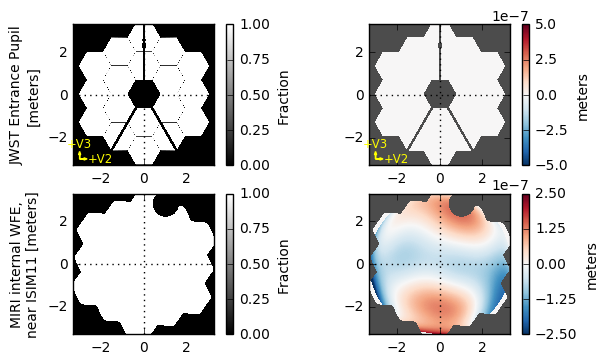

In [9]:
plt.figure(figsize=(7, 4))
miri.display()

A few things have changed compared to the last plot of the optical train. The wavefront error map has changed, as expected with a change in field position. There is also a change to the transmission of the oversized MIRI pupil mask. This is a field-dependent obscuration from the MIRI internal calibration source pickoff mirror.

Now, let's compute a PSF at the new position (call it `miri_psf_corner`), and perform the comparison.

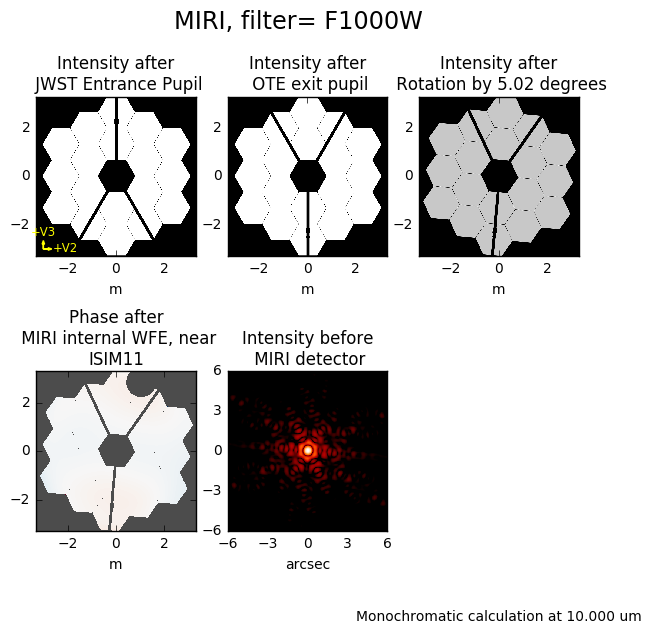

In [10]:
plt.figure(figsize=(7, 6.5))
miri_psf_corner = miri.calc_psf(monochromatic=10e-6, display=True)

### Compare MIRI ideal to realistic PSF

Let's compare some of the output PSFs. The differences are pretty minor in this case. 

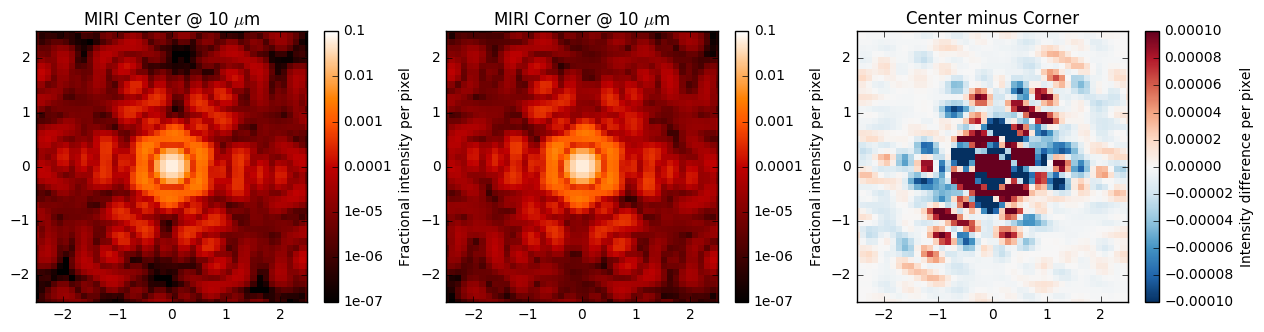

In [11]:
fig, (ax_ideal, ax_realistic, ax_diff) = plt.subplots(1, 3,
                                                      figsize=(15, 3.5))
webbpsf.display_psf(miri_psf_center, ext='DET_SAMP',
                    title='MIRI Center @ 10 $\mu$m',
                    ax=ax_ideal, imagecrop=5)
webbpsf.display_psf(miri_psf_corner, ext='DET_SAMP',
                    title='MIRI Corner @ 10 $\mu$m',
                    ax=ax_realistic, imagecrop=5)
webbpsf.display_psf_difference(miri_psf_center, miri_psf_corner,
                               ext1='DET_SAMP', ext2='DET_SAMP',
                               title='Center minus Corner',
                               ax=ax_diff, cmap='RdBu_r',
                               imagecrop=5)